[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=== Dataset Sizes ===
ISOT: (38558, 2)
WELFake: (62573, 2)


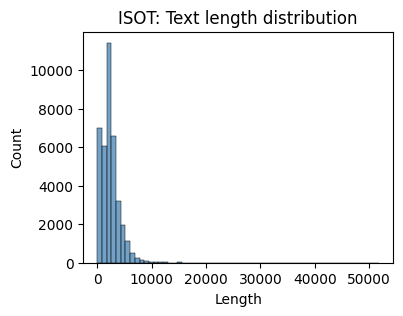

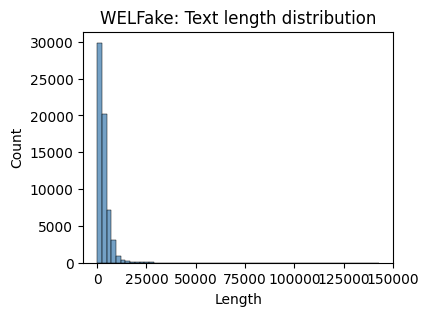


--- Classical ML Results (ISOT) ---
LogReg Accuracy: 0.9818464730290456
SVM Accuracy: 0.9897562240663901

--- Classical ML Results (WELFake) ---
LogReg Accuracy: 0.939752297243308
SVM Accuracy: 0.9519776268477826


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/30846 [00:00<?, ? examples/s]

Map:   0%|          | 0/7712 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.000100,0.001974,0.999741
2,0.000000,0.002039,0.999741



=== distilbert-base-uncased (ISOT) Results ===
{'eval_loss': 0.0019742606673389673, 'eval_accuracy': 0.9997406639004149, 'eval_runtime': 9.5725, 'eval_samples_per_second': 805.639, 'eval_steps_per_second': 100.705, 'epoch': 2.0}


Map:   0%|          | 0/50058 [00:00<?, ? examples/s]

Map:   0%|          | 0/12515 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.041200,0.052822,0.987375
2,0.005600,0.043699,0.991051



=== distilbert-base-uncased (WELFake) Results ===
{'eval_loss': 0.0436992347240448, 'eval_accuracy': 0.9910507391130643, 'eval_runtime': 15.8693, 'eval_samples_per_second': 788.631, 'eval_steps_per_second': 98.618, 'epoch': 2.0}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/30846 [00:00<?, ? examples/s]

Map:   0%|          | 0/7712 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.001800,0.007768,0.999222
2,0.000000,0.001741,0.999870



=== roberta-large (ISOT) Results ===
{'eval_loss': 0.0017408280400559306, 'eval_accuracy': 0.9998703319502075, 'eval_runtime': 27.8663, 'eval_samples_per_second': 276.75, 'eval_steps_per_second': 34.594, 'epoch': 2.0}


Map:   0%|          | 0/50058 [00:00<?, ? examples/s]

Map:   0%|          | 0/12515 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.014500,0.017200,0.998002


Epoch,Training Loss,Validation Loss,Accuracy
1,0.014500,0.017200,0.998002
2,0.005400,0.012277,0.998242



=== roberta-large (WELFake) Results ===
{'eval_loss': 0.012276542373001575, 'eval_accuracy': 0.9982421094686377, 'eval_runtime': 45.2731, 'eval_samples_per_second': 276.433, 'eval_steps_per_second': 34.568, 'epoch': 2.0}


===== FINAL TRANSFORMER MODEL COMPARISON =====
   Dataset          Model  Accuracy
0     ISOT     DistilBERT  0.999741
1     ISOT  RoBERTa-Large  0.999870
2  WELFake     DistilBERT  0.991051
3  WELFake  RoBERTa-Large  0.998242


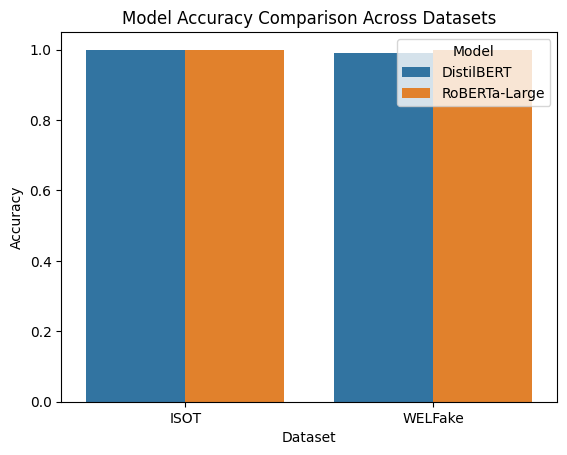

In [5]:
# =========================
#   FAKE NEWS PROJECT
#   ISOT + WeLFake | EDA → ML → Transformers → Comparison
# =========================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import evaluate
from datasets import Dataset
import torch
import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")

# =========================================================
# 1. LOAD DATASETS — YOUR CORRECT PATHS
# =========================================================

isot_path = "/content/drive/MyDrive/Colab Notebooks/data_clean/clean_isot.csv"
wel_path  = "/content/drive/MyDrive/Colab Notebooks/data_clean/clean_welfake.csv"

isot = pd.read_csv(isot_path)
wel  = pd.read_csv(wel_path)

# make sure correct text column exists
text_col = "text" if "text" in isot.columns else isot.columns[0]
label_col = "label"

isot = isot[[text_col, label_col]].rename(columns={text_col:"text"})
wel  = wel[[text_col, label_col]].rename(columns={text_col:"text"})

# =========================================================
# 2. BASIC EDA
# =========================================================

def plot_text_length(df, name):
    text_col = df["text"]
    if isinstance(text_col, pd.DataFrame):
        text_col = text_col.iloc[:,0]
    lens = text_col.astype(str).apply(len)

    plt.figure(figsize=(4,3))
    sns.histplot(lens, bins=60, color="steelblue")
    plt.title(f"{name}: Text length distribution")
    plt.xlabel("Length")
    plt.ylabel("Count")
    plt.show()

print("=== Dataset Sizes ===")
print("ISOT:", isot.shape)
print("WELFake:", wel.shape)

plot_text_length(isot, "ISOT")
plot_text_length(wel, "WELFake")

# =========================================================
# 3. Classical ML Baseline (TF-IDF + Logistic Regression + SVM)
# =========================================================

def classical_ml(df, name):
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
    )

    tfidf = TfidfVectorizer(stop_words="english", max_features=50000)
    Xtr = tfidf.fit_transform(X_train)
    Xte = tfidf.transform(X_test)

    # Logistic Regression
    logreg = LogisticRegression(max_iter=3000)
    logreg.fit(Xtr, y_train)
    log_acc = accuracy_score(y_test, logreg.predict(Xte))

    # Linear SVM
    svm = LinearSVC()
    svm.fit(Xtr, y_train)
    svm_acc = accuracy_score(y_test, svm.predict(Xte))

    print(f"\n--- Classical ML Results ({name}) ---")
    print("LogReg Accuracy:", log_acc)
    print("SVM Accuracy:", svm_acc)

    return log_acc, svm_acc

log_isot, svm_isot = classical_ml(isot, "ISOT")
log_wel,  svm_wel  = classical_ml(wel,  "WELFake")

# =========================================================
# 4. Helper for Transformers
# =========================================================

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=preds, references=labels)

def train_transformer(df, model_name, label):
    train_df, test_df = train_test_split(
        df, test_size=0.2, random_state=42, stratify=df["label"]
    )

    train_ds = Dataset.from_pandas(train_df)
    test_ds  = Dataset.from_pandas(test_df)

    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tok(x):
        return tokenizer(x["text"], truncation=True, max_length=256)

    train_tok = train_ds.map(tok, batched=True)
    test_tok  = test_ds.map(tok, batched=True)

    collator = DataCollatorWithPadding(tokenizer)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=2
    )

    args = TrainingArguments(
        output_dir=f"./{label}_{model_name}",
        num_train_epochs=2,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        learning_rate=2e-5,
        eval_strategy="epoch",
        save_strategy="epoch",
        fp16=True,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        report_to="none"
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        tokenizer=tokenizer,
        data_collator=collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    result = trainer.evaluate()
    print(f"\n=== {model_name} ({label}) Results ===")
    print(result)
    return result["eval_accuracy"]

# =========================================================
# 5. DISTILBERT + ROBERTA-LARGE ON BOTH DATASETS
# =========================================================

distil_isot  = train_transformer(isot, "distilbert-base-uncased", "ISOT")
distil_wel   = train_transformer(wel,  "distilbert-base-uncased", "WELFake")

roberta_isot = train_transformer(isot, "roberta-large", "ISOT")
roberta_wel  = train_transformer(wel,  "roberta-large", "WELFake")

# =========================================================
# 6. FINAL COMPARISON TABLE
# =========================================================

results = pd.DataFrame({
    "Dataset": ["ISOT", "ISOT", "WELFake", "WELFake"],
    "Model": ["DistilBERT", "RoBERTa-Large", "DistilBERT", "RoBERTa-Large"],
    "Accuracy": [distil_isot, roberta_isot, distil_wel, roberta_wel]
})

print("\n\n===== FINAL TRANSFORMER MODEL COMPARISON =====")
print(results)
sns.barplot(data=results, x="Dataset", y="Accuracy", hue="Model")
plt.title("Model Accuracy Comparison Across Datasets")
plt.show()
